<a href="https://colab.research.google.com/github/imjoung/DataScience/blob/main/ml/13_Titanic_Classification_Ensemble_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

문제 정의 : 타이타닉 생존자 예측 데이터 셋 사용하여 유무를 예측하는 이진 분류 문제로 정의<br>
사망 : 0, 생존 : 1

In [1]:
# Libraries for reading and handling the data
import numpy as np
import pandas as pd
import re

# Libraries for data cisualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Libraries for creating ML model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Library for Analysing the ML model
from sklearn import metrics

### step1) 데이터 준비하기

In [2]:
train_path = 'train.csv'
target = 'Survived'
index = 'PassengerId'

dtypes = ({
    'Survived': bool, 
    'Pclass':   'category', 
    'Name':     'category',
    'Sex':      'category',
    'Age':      float,
    'SibSp':    int,
    'Parch':    int,
    'Ticket':  'category',
    'Fare':     float,
    'Cabin':   'category',
    'Embarked':'category'
})

titanic = pd.read_csv(train_path, index_col=index, dtype=dtypes)

# 데이터 살펴보기
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    bool    
 1   Pclass    891 non-null    category
 2   Name      891 non-null    category
 3   Sex       891 non-null    category
 4   Age       714 non-null    float64 
 5   SibSp     891 non-null    int64   
 6   Parch     891 non-null    int64   
 7   Ticket    891 non-null    category
 8   Fare      891 non-null    float64 
 9   Cabin     204 non-null    category
 10  Embarked  889 non-null    category
dtypes: bool(1), category(6), float64(2), int64(2)
memory usage: 122.2 KB


### step 2) 데이터 시각화

In [3]:
titanic['Survived'].value_counts()

False    549
True     342
Name: Survived, dtype: int64

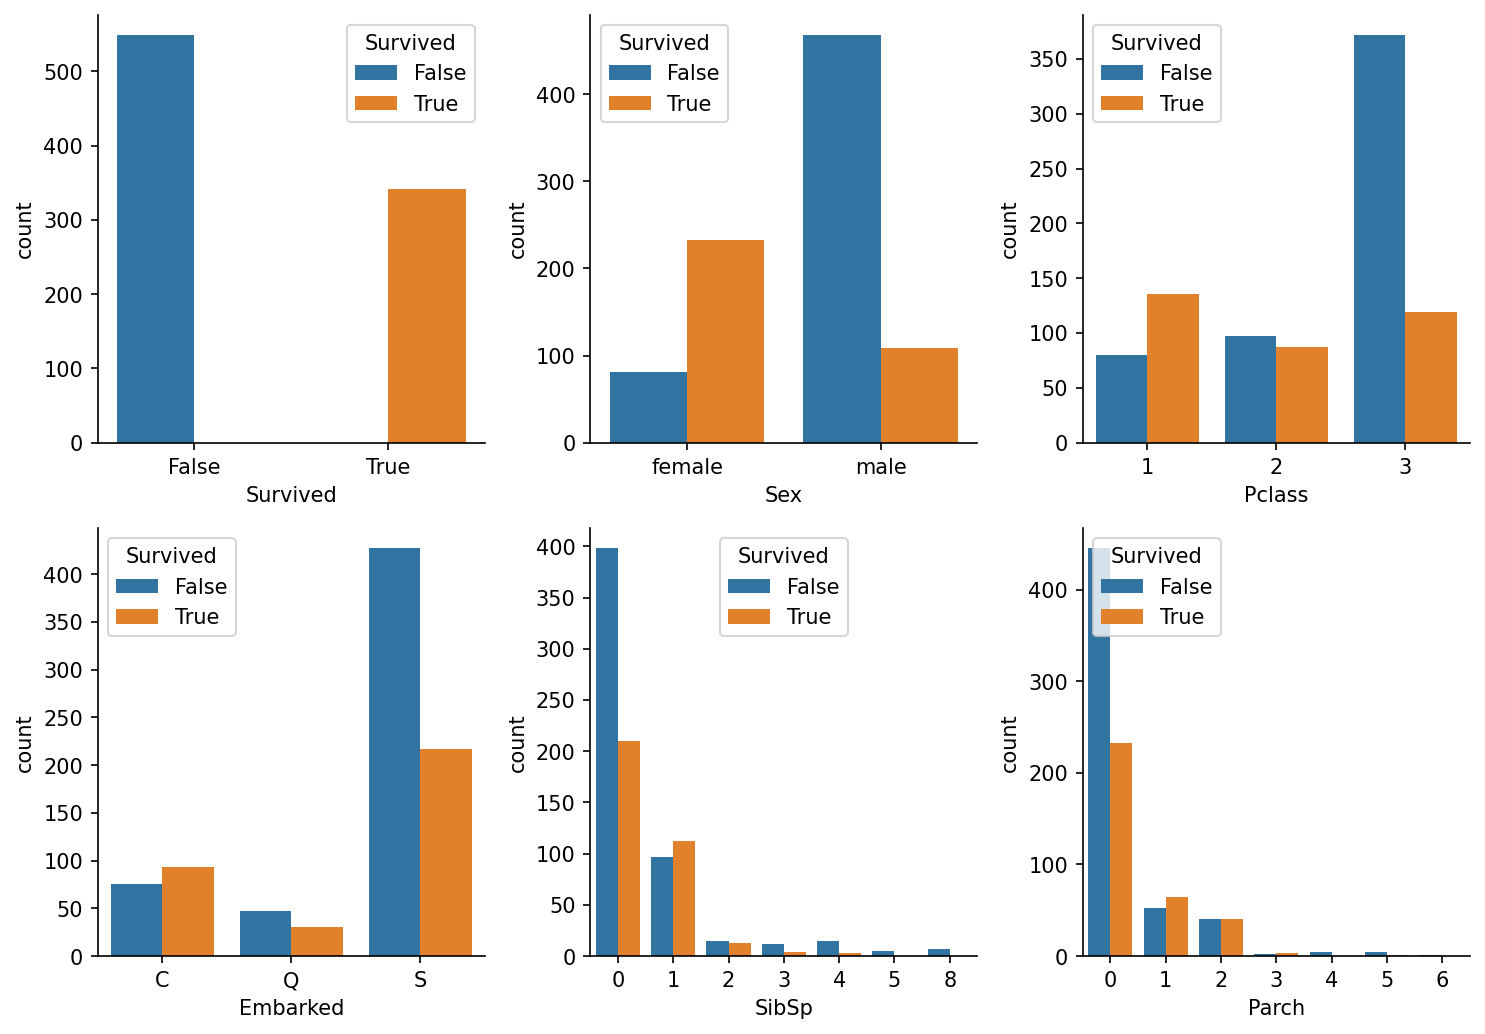

In [4]:
attributes = ['Survived','Sex','Pclass','Embarked','SibSp','Parch']

plt.figure(figsize=(10,10),dpi=150)

for i, feature in enumerate(attributes) :
  plt.subplot(3,3,i+1)
  sns.countplot(data=titanic, x=feature, hue='Survived')

plt.tight_layout()
sns.despine()

### step 3) 데이터 전처리

In [5]:
titanic['Name'].iloc[-5:]

PassengerId
887                       Montvila, Rev. Juozas
888                Graham, Miss. Margaret Edith
889    Johnston, Miss. Catherine Helen "Carrie"
890                       Behr, Mr. Karl Howell
891                         Dooley, Mr. Patrick
Name: Name, dtype: category
Categories (891, object): ['Abbing, Mr. Anthony', 'Abbott, Mr. Rossmore Edward',
                           'Abbott, Mrs. Stanton (Rosa Hunt)', 'Abelson, Mr. Samuel', ..., 'de Pelsmaeker, Mr. Alfons',
                           'del Carlo, Mr. Sebastiano', 'van Billiard, Mr. Austin Blyler',
                           'van Melkebeke, Mr. Philemon']

In [6]:
def get_title(name) :
  return re.split(',|\.',name)[1].strip()

In [7]:
# 이름에서 호칭 추출(Mr/ Miss / Mrs / ...)
titanic['title'] = titanic['Name'].apply(get_title)

In [8]:
# 호칭이 생존에 과연 영향을 끼치는지 확인을 위해서 집계 함수 
# -> count(카운트), mean(평균)
titles = titanic.groupby('title').agg({'Survived' : ['count','mean']})

In [9]:
# Survived 컬럼 레이어 정리 (멀티 레이어 삭제)
titles.columns = titles.columns.droplevel()

In [10]:
# 생존 평균이 높은 순으로 정렬
titles.sort_values('mean',ascending=False)

,count,mean
title,,
the Countess,1,1.000000
Mlle,2,1.000000
Sir,1,1.000000
Ms,1,1.000000
Lady,1,1.000000
Mme,1,1.000000
Mrs,125,0.792000
Miss,182,0.697802
Master,40,0.575000


In [11]:
# 호칭 추출이 되지 않은 title값을 other로 처리
uncommon_titles = (['Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 
                    'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 
                    'the Countess', 'Jonkheer'])
titanic['title'] = titanic['title'].replace(uncommon_titles, 'other')

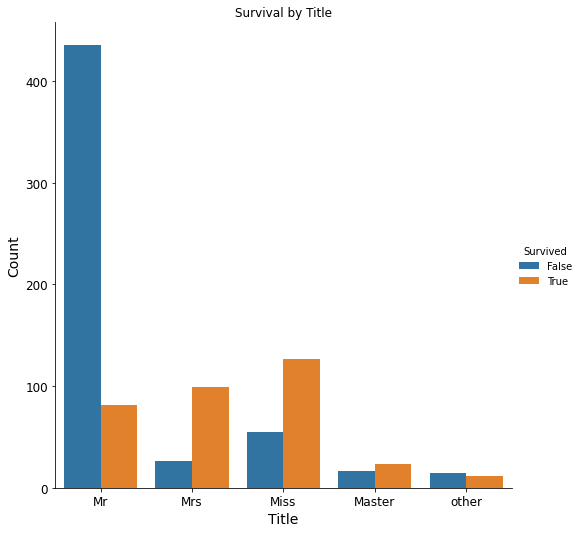

In [12]:
# 시각화
sns.catplot(x='title', kind='count', hue='Survived', 
            data=titanic, height=7)
plt.tick_params(labelsize=12)
plt.ylabel('Count',fontsize=14)
plt.xlabel('Title',fontsize=14)
plt.title('Survival by Title')
plt.show()

In [13]:
# 가족 사이즈: fam_size()  ==>
# 동승한 자매 or 배우자 : SibSp() + 동승한 부모 or 자식 수 : Parch()
titanic['fam_size'] = titanic['SibSp'] + titanic['Parch']

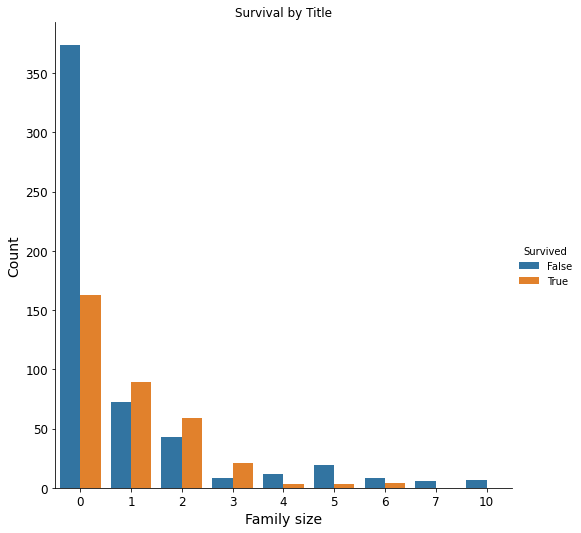

In [14]:
# 시각화
sns.catplot(x='fam_size', kind='count', hue='Survived', 
            data=titanic, height=7)
plt.tick_params(labelsize=12)
plt.ylabel('Count',fontsize=14)
plt.xlabel('Family size',fontsize=14)
plt.title('Survival by Title')
plt.show()

### step 4) ML을 위한 전처리

In [15]:
# 텍스트 데이터 삭제
titanic = titanic.drop(['Name','Ticket','Cabin', 'Embarked','title'], axis=1)

In [16]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,fam_size
PassengerId,,,,,,,,
1,False,3,male,22.0,1,0,7.2500,1
2,True,1,female,38.0,1,0,71.2833,1
3,True,3,female,26.0,0,0,7.9250,0
4,True,1,female,35.0,1,0,53.1000,1
5,False,3,male,35.0,0,0,8.0500,0


In [17]:
# 여성을 1, 남성을 0으로 처리
tmp = []
for each in titanic['Sex']:
  if each == 'female': 
    tmp.append(1)
  elif each == 'male': 
    tmp.append(0)
  else : 
    temp.append(np.nan)

titanic['Sex'] = tmp

 데이터 형변환 및 결손 데이터 처리

In [18]:
# 데이터 형 변환(소수점)
titanic['Pclass'] = titanic['Pclass'].astype('float')
titanic['Sex'] = titanic['Sex'].astype('float')
titanic['SibSp'] = titanic['SibSp'].astype('float')
titanic['Parch'] = titanic['Parch'].astype('float')
titanic['Fare'] = titanic['Fare'].astype('float')

#null(결손) 값인 경우 삭제
titanic = titanic[titanic['Survived'].notnull()]
titanic = titanic[titanic['Age'].notnull()]
titanic = titanic[titanic['SibSp'].notnull()]
titanic = titanic[titanic['Parch'].notnull()]
titanic = titanic[titanic['Fare'].notnull()]


In [19]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  714 non-null    bool   
 1   Pclass    714 non-null    float64
 2   Sex       714 non-null    float64
 3   Age       714 non-null    float64
 4   SibSp     714 non-null    float64
 5   Parch     714 non-null    float64
 6   Fare      714 non-null    float64
 7   fam_size  714 non-null    int64  
dtypes: bool(1), float64(6), int64(1)
memory usage: 45.3 KB


### step 6) 데이터 분리하기 X,y

In [20]:
titanic_labels = titanic['Survived'].copy()
titanic = titanic.drop('Survived', axis=1)

In [21]:
# 훈련 데이터, 테스트 데이터셋 분리하기
X_train,X_test,y_train,y_test = train_test_split(titanic,
                                                 titanic_labels,
                                                 train_size=0.8)

### step 7) ML모델 구축 
- Logistic Regression

In [22]:
# Logistic 
log_reg = LogisticRegression().fit(X_train,y_train)

# 정확도 확인
print('Train data Score : {:.3f}'.format(log_reg.score(X_train,y_train)))
print('Test data Score : {:.3f}'.format(log_reg.score(X_test,y_test))) 

Train data Score : 0.814
Test data Score : 0.790


- Decision Tree

In [23]:
# Decision tree
tree = DecisionTreeClassifier(max_depth=5,
                              min_samples_leaf=20,
                              min_samples_split=40).fit(X_train,y_train)

# 정확도 확인
print('Train data Score : {:.3f}'.format(tree.score(X_train,y_train)))
print('Test data Score : {:.3f}'.format(tree.score(X_test,y_test)))

Train data Score : 0.825
Test data Score : 0.797


- Random Forest

In [24]:
# Random Forest (앙상블)
random = RandomForestClassifier(n_estimators=300,
                                random_state=0).fit(X_train,y_train)

# 정확도 확인
print('Train data Score : {:.3f}'.format(random.score(X_train,y_train)))
print('Test data Score : {:.3f}'.format(random.score(X_test,y_test)))

Train data Score : 0.989
Test data Score : 0.762


- Grandient boosting

In [25]:
# Grandient boosting (앙상블)
boost = GradientBoostingClassifier(max_depth=5,
                                   learning_rate=0.05).fit(X_train,y_train)

# 정확도 확인
print('Train data Score : {:.3f}'.format(boost.score(X_train,y_train)))
print('Test data Score : {:.3f}'.format(boost.score(X_test,y_test)))

Train data Score : 0.946
Test data Score : 0.804


### step 8) 성능평가 - ROC 커브

In [26]:
# 분류모델은 ROC커브 그려보기
def plot_auc_roc(model):
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

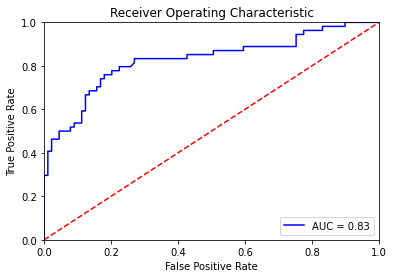

In [27]:
# Logistic - ROC
plot_auc_roc(log_reg)

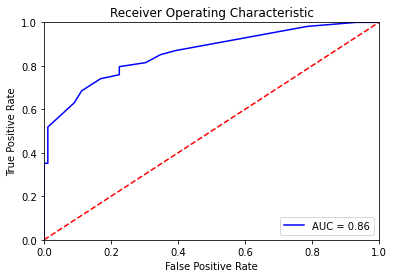

In [28]:
# Decision tree - ROC
plot_auc_roc(tree)

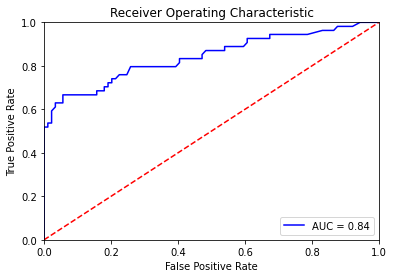

In [29]:
# Random Forest - roc
plot_auc_roc(random)

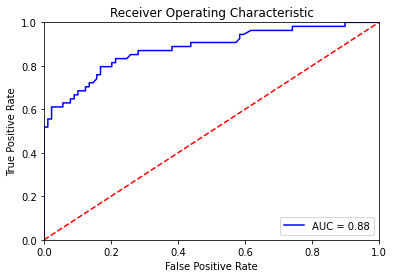

In [30]:
# Gradient boosting - roc
plot_auc_roc(boost)

### step 8) 모델 성능 평가

In [31]:
# Logistic Regression 평가 지표
lg_y_hat = log_reg.predict(X_test)
lg_report = metrics.classification_report(y_test,lg_y_hat)
print("Logistic Regression 평가 지표",'\n')
print(lg_report)

print('accuracy', metrics.accuracy_score(y_test,lg_y_hat) )
print('precision', metrics.precision_score(y_test,lg_y_hat) )
print('recall', metrics.recall_score(y_test,lg_y_hat) )
print('f1', metrics.f1_score(y_test,lg_y_hat) )

Logistic Regression 평가 지표 

              precision    recall  f1-score   support

       False       0.83      0.83      0.83        89
        True       0.72      0.72      0.72        54

    accuracy                           0.79       143
   macro avg       0.78      0.78      0.78       143
weighted avg       0.79      0.79      0.79       143

accuracy 0.7902097902097902
precision 0.7222222222222222
recall 0.7222222222222222
f1 0.7222222222222222


In [32]:
# Decision tree 평가 지표
tree_y_hat = tree.predict(X_test)
tree_report = metrics.classification_report(y_test,tree_y_hat)
print("Decision tree 평가 지표",'\n')
print(tree_report)

print('accuracy', metrics.accuracy_score(y_test,tree_y_hat) )
print('precision', metrics.precision_score(y_test,tree_y_hat) )
print('recall', metrics.recall_score(y_test,tree_y_hat) )
print('f1', metrics.f1_score(y_test,tree_y_hat) )


Decision tree 평가 지표 

              precision    recall  f1-score   support

       False       0.84      0.83      0.84        89
        True       0.73      0.74      0.73        54

    accuracy                           0.80       143
   macro avg       0.78      0.79      0.79       143
weighted avg       0.80      0.80      0.80       143

accuracy 0.7972027972027972
precision 0.7272727272727273
recall 0.7407407407407407
f1 0.7339449541284404


In [33]:
# Random Forest 평가 지표
random_y_hat = random.predict(X_test)
random_report = metrics.classification_report(y_test,random_y_hat)
print(" Random Forest 평가 지표",'\n')
print(random_report)

print('accuracy', metrics.accuracy_score(y_test,random_y_hat) )
print('precision', metrics.precision_score(y_test,random_y_hat) )
print('recall', metrics.recall_score(y_test,random_y_hat) )
print('f1', metrics.f1_score(y_test,random_y_hat) )


 Random Forest 평가 지표 

              precision    recall  f1-score   support

       False       0.84      0.76      0.80        89
        True       0.66      0.76      0.71        54

    accuracy                           0.76       143
   macro avg       0.75      0.76      0.75       143
weighted avg       0.77      0.76      0.76       143

accuracy 0.7622377622377622
precision 0.6612903225806451
recall 0.7592592592592593
f1 0.7068965517241378


In [34]:
# Grandient boosting 평가 지표
boost_y_hat = boost.predict(X_test)
boost_report = metrics.classification_report(y_test,boost_y_hat)
print("Grandient  boosting 평가 지표",'\n')
print(boost_report)

print('accuracy', metrics.accuracy_score(y_test,boost_y_hat) )
print('precision', metrics.precision_score(y_test,boost_y_hat) )
print('recall', metrics.recall_score(y_test,boost_y_hat) )
print('f1', metrics.f1_score(y_test,boost_y_hat) )


Grandient  boosting 평가 지표 

              precision    recall  f1-score   support

       False       0.84      0.85      0.84        89
        True       0.75      0.72      0.74        54

    accuracy                           0.80       143
   macro avg       0.79      0.79      0.79       143
weighted avg       0.80      0.80      0.80       143

accuracy 0.8041958041958042
precision 0.75
recall 0.7222222222222222
f1 0.7358490566037735


In [35]:
precision_list = []
recall_list=[]

# Logistic
precision_list.append(metrics.precision_score(y_test,lg_y_hat))
recall_list.append(metrics.recall_score(y_test,lg_y_hat))

# decision
precision_list.append(metrics.precision_score(y_test,tree_y_hat))
recall_list.append(metrics.recall_score(y_test,tree_y_hat))

# RF
precision_list.append(metrics.precision_score(y_test,random_y_hat))
recall_list.append(metrics.recall_score(y_test,random_y_hat))

# boost
precision_list.append(metrics.precision_score(y_test,boost_y_hat))
recall_list.append(metrics.recall_score(y_test,boost_y_hat))

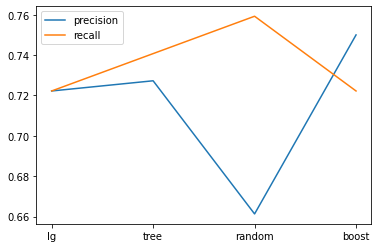

In [36]:
plt.plot(['lg','tree','random','boost'],precision_list, label='precision')
plt.plot(['lg','tree','random','boost'],recall_list, label='recall')
plt.legend()
plt.show()